# ECG classification

Laurent Cetinsoy - Datadidacte


In [ ]:
!pip install PyWavelets

In [ ]:
from google.colab import drive
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing
import pandas as pd
import pywt
import scipy
import seaborn as sns
import tensorflow as tf

sns.set_theme()

In [ ]:
drive.mount("/content/drive")
dataset_root = Path("/content/drive/MyDrive/MLBIO/datasets")
!unzip -n {dataset_root / "ECG_classification_full_dataset.zip"}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/drive/MyDrive/MLBIO/datasets/ECG_classification_full_dataset.zip


## A first naive model by extracting simple features


Your environment contains variables `arr`, `nsr`, and `chf` which respectively contain 10-second recordings of ECG signals extracted from three datasets on PhysioNet: one from a person suffering from arrhythmia, one from a person with a normal heart rhythm, and another from a person with heart failure.

Matplotlib subplots (or any other library), display these signals on three subfigures (the subplots should be called with the parameter `nrows=3`).
Can you find any differences between them?

In [ ]:
arr = np.loadtxt(dataset_root / "arr.txt")
nsr = np.loadtxt(dataset_root / "nsr.txt")
chf = np.loadtxt(dataset_root / "chf.txt")

In [ ]:
signals = {
    "arr": arr,
    "nsr": nsr,
    "chf": chf,
}

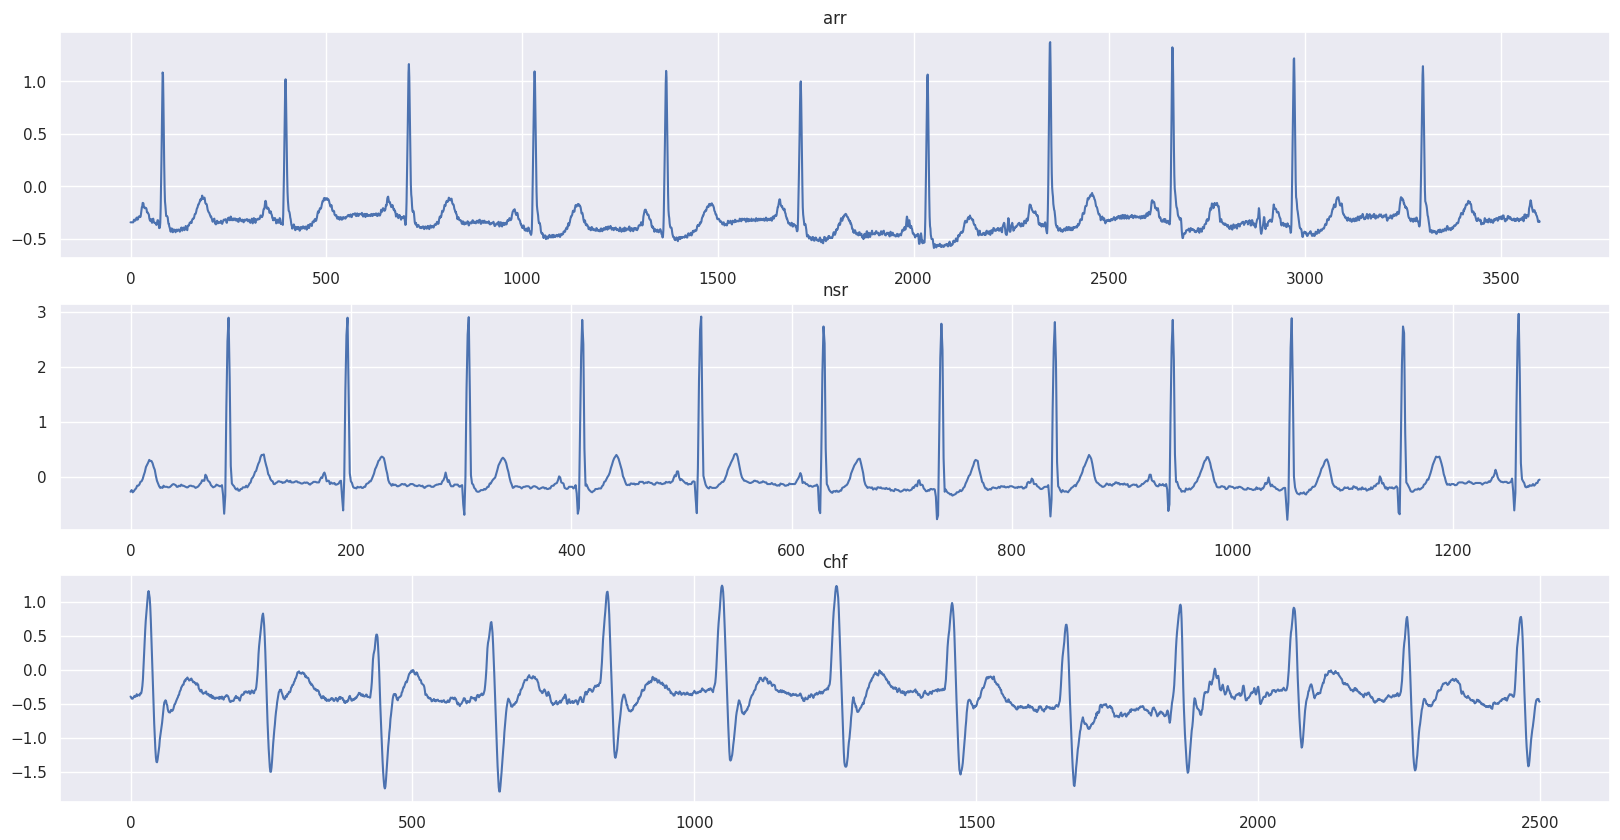

In [ ]:
fig, axs = plt.subplots(nrows=len(signals), figsize=(20, 10))
for ax, (key, signal) in zip(axs, signals.items()):
    ax.set_title(key)
    sns.lineplot(signal, ax=ax)
plt.show()

We want to extract features from the time series. For that we will use simple statistics.

Create a function named `calculate_stats_features(x)` that calculates some statistical features of a signal `x` using standard numpy functions: `nanpercentile`, `nanmean`, etc.

`calculate_stats_features` will return a list of features in this order:

1. Max
2. Min
3. Mean
4. Median
5. Variance

In [ ]:
def calculate_stats_features(x: numpy.typing.NDArray) -> list[float]:
    return [np.nanmax(x), np.nanmin(x), np.nanmean(x), np.nanpercentile(x, 0.5), np.nanvar(x)]

In [ ]:
for key, signal in signals.items():
    print(f"calculate_stats_features({key}) = {calculate_stats_features(signal)}")

calculate_stats_features(arr) = [1.375, -0.59, -0.3120111111111112, -0.57, 0.039663552654320984]
calculate_stats_features(nsr) = [2.965, -0.785, -0.035453124999999995, -0.675, 0.21755463842773434]
calculate_stats_features(chf) = [1.235, -1.79, -0.363622, -1.5902, 0.15541165111599997]




Create a function named `calculate_zero_crossing(x)` that calculates the Zero
Crossing of a signal `x`.

The zero crossing is defined as the number of times the signal changes sign.
For this, you can use the `signbit`, `diff`, and `nonzero` functions from numpy.


In [ ]:
def calculate_zero_crossing(x: numpy.typing.NDArray) -> int:
    return np.diff(np.signbit(x)).sum()

In [ ]:
for key, signal in signals.items():
    print(f"calculate_zero_crossing({key}) = {calculate_zero_crossing(signal)}")

calculate_zero_crossing(arr) = 22
calculate_zero_crossing(nsr) = 66
calculate_zero_crossing(chf) = 28


Create a function named `calculate_rms(x)` that returns the Root Mean Square (RMS) of a signal `x`. We will use the `nanmean` function instead of the `mean` function from numpy.

In [ ]:
def calculate_rms(x: numpy.typing.NDArray) -> float:
    return np.sqrt(np.nanmean(np.square(x)))

In [ ]:
for key, signal in signals.items():
    print(f"calculate_rms({key}) = {calculate_rms(signal)}")

calculate_rms(arr) = 0.37015467862923346
calculate_rms(nsr) = 0.46777298179779475
calculate_rms(chf) = 0.5363139099445399


Create a function named `calculate_entropy(x)` that calculates the Shannon entropy of a signal `x` using the entropy function from `scipy.stats`.

In [ ]:
def calculate_entropy(x: numpy.typing.NDArray) -> float:
    _, counts = np.unique(x, return_counts=True)
    return scipy.stats.entropy(counts)

In [ ]:
for key, signal in signals.items():
    print(f"calculate_entropy({key}) = {calculate_entropy(signal)}")

calculate_entropy(arr) = 4.444550643807692
calculate_entropy(nsr) = 3.9597588364931857
calculate_entropy(chf) = 5.298054917262371


Create a function `get_features(x)` that combines the features calculated by all previous functions including `calculate_stats_features`.

In [ ]:
def get_features(x: numpy.typing.NDArray) -> list[float]:
    features = calculate_stats_features(x)
    features += [
        calculate_zero_crossing(x),
        calculate_rms(x),
        calculate_entropy(x),
    ]
    return features

Load the small ECG dataset.

Use your function `get_features` create a new dataframe where you have all the feature as `X` and `y` as the label.

Train a random forest on it after doing a train test split if the dataset is not too small.

In [ ]:
def load_dataset(
    filepath: Path,
) -> tuple[pd.DataFrame, numpy.typing.NDArray, numpy.typing.NDArray]:
    dataset = pd.read_csv(filepath, low_memory=False)
    dataset.drop(columns=["0"], inplace=True)
    signals = dataset.drop(columns=["1"]).values
    feature_keys = ["max", "min", "mean", "median", "variance", "zero_crossing", "rms", "entropy"]
    feature_values = np.transpose(list(map(get_features, signals)))
    features = pd.DataFrame(dict(zip(feature_keys, feature_values)))
    labels = dataset["1"].values
    return features, labels, signals

In [ ]:
features, labels, signals = load_dataset(dataset_root / "ecg_small_dataset.csv")
features

,max,min,mean,median,variance,zero_crossing,rms,entropy
0,1.002118,-0.592731,-0.340759,-0.512927,0.032634,358.0,0.385683,9.639522
1,-0.281521,-0.923734,-0.510468,-0.804459,0.003658,0.0,0.514039,9.639522
2,1.235749,-2.492697,-0.344063,-1.708050,0.146738,418.0,0.514895,9.639522
3,1.295494,-3.105455,-0.195126,-2.785542,0.721041,384.0,0.871272,9.639522
4,2.445000,-1.005000,-0.046349,-0.705000,0.133627,1150.0,0.368477,6.237319
5,1.645000,-1.265000,-0.077669,-1.015000,0.064813,812.0,0.266167,5.676426


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    features,
    labels,
    train_size=0.5,
    random_state=42,
    shuffle=True,
    stratify=labels,
)

In [ ]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred = clf.predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3



In [ ]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3



Now you have a first pipeline, do the same on the full dataset.

Report the train and test loss.

In [ ]:
features, labels, signals = load_dataset("./ECG-laurent.csv")
features

,max,min,mean,median,variance,zero_crossing,rms,entropy
0,3.006143,-2.460911,-0.268554,-1.641286,0.420271,4154.0,0.701707,11.090355
1,2.527708,-3.550697,-0.221014,-3.184328,0.536639,3768.0,0.765171,11.090355
2,2.264555,-3.929179,-0.163022,-1.742045,0.182135,2253.0,0.456849,11.090355
3,3.055421,-1.906982,0.053962,-1.188166,0.158568,3102.0,0.401846,11.090355
4,2.035001,-1.575197,-0.148872,-0.915734,0.111417,4748.0,0.365486,11.090355
...,...,...,...,...,...,...,...,...
157,0.635837,-2.036593,-0.217742,-1.664237,0.165278,2068.0,0.461183,11.090355
158,2.777683,-1.408466,-0.270539,-0.997052,0.023627,692.0,0.311157,11.090355
159,0.919894,-1.070185,-0.172078,-0.769046,0.018569,1762.0,0.219498,11.090355
160,7.078177,-5.961910,-0.343730,-2.372081,0.545255,3645.0,0.814497,11.090355


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    features,
    labels,
    train_size=0.8,
    random_state=42,
    shuffle=True,
    stratify=labels,
)

In [ ]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred = clf.predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       1.00      1.00      1.00        76
           2       1.00      1.00      1.00        24

    accuracy                           1.00       129
   macro avg       1.00      1.00      1.00       129
weighted avg       1.00      1.00      1.00       129



In [ ]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.95      1.00      0.98        20
           2       1.00      0.83      0.91         6

    accuracy                           0.97        33
   macro avg       0.98      0.94      0.96        33
weighted avg       0.97      0.97      0.97        33



In [ ]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.95      1.00      0.98        20
           2       1.00      0.83      0.91         6

    accuracy                           0.97        33
   macro avg       0.98      0.94      0.96        33
weighted avg       0.97      0.97      0.97        33



Try to tweak the model hyperparameter to see if it works.

In [ ]:
param_grid = {
    'n_estimators': list(range(3, 21)),
    'max_depth': [None] + list(range(1, 5)),
}

clf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, n_jobs=-1)
clf.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 1, 2, 3, 4],
                         'n_estimators': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                          14, 15, 16, 17, 18, 19, 20]})

In [ ]:
y_pred = clf.predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       0.96      0.99      0.97        76
           2       0.95      0.88      0.91        24

    accuracy                           0.97       129
   macro avg       0.97      0.95      0.96       129
weighted avg       0.97      0.97      0.97       129



In [ ]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.86      0.90      0.88        20
           2       0.60      0.50      0.55         6

    accuracy                           0.85        33
   macro avg       0.82      0.80      0.81        33
weighted avg       0.84      0.85      0.84        33



## Fourier transform features

We want now to see if a model using only Fourier transform could work.

Create a function `get_fourier_coefficients(x)`.

In [ ]:
get_fourier_coefficients = scipy.fft.fft

Using this function create a dataframe `df_fourier` containing the Fourier transform coefficients and the label.

In [ ]:
fourier_coeffs = np.array(list(map(get_fourier_coefficients, signals)))
df_fourier = pd.DataFrame(fourier_coeffs)
df_fourier["label"] = labels
df_fourier

,0,1,2,3,4,5,6,7,8,9,...,65527,65528,65529,65530,65531,65532,65533,65534,65535,label
0,-17599.976889- 0.000000j,-758.813702+1687.405284j,-93.278558+ 280.216281j,-592.319401+1026.974542j,-305.129117+ 874.691769j,-385.483756+ 375.715346j,-791.780539- 242.670694j,-459.654824+ 514.271858j,-1258.509759+ 920.385729j,315.708424+444.816694j,...,315.708424-444.816694j,-1258.509759- 920.385729j,-459.654824- 514.271858j,-791.780539+ 242.670694j,-385.483756- 375.715346j,-305.129117- 874.691769j,-592.319401-1026.974542j,-93.278558- 280.216281j,-758.813702-1687.405284j,1
1,-14484.396444- 0.000000j,-1625.487534+3804.824702j,-1115.147467+1840.987195j,-592.487213+2449.796028j,-554.254257+1990.932926j,-285.183354+1615.775623j,296.268696+1551.541640j,-204.265852+ 923.334693j,-1635.338876+ 204.897677j,865.993022+823.689927j,...,865.993022-823.689927j,-1635.338876- 204.897677j,-204.265852- 923.334693j,296.268696-1551.541640j,-285.183354-1615.775623j,-554.254257-1990.932926j,-592.487213-2449.796028j,-1115.147467-1840.987195j,-1625.487534-3804.824702j,1
2,-10683.818667- 0.000000j,385.954517- 106.818044j,-196.939828- 439.417834j,-224.784712+ 693.963979j,-96.282300- 960.107957j,-673.024888- 665.055041j,-577.757255- 221.238689j,-508.416037-1121.356596j,67.634488- 47.279031j,-900.547863+131.756620j,...,-900.547863-131.756620j,67.634488+ 47.279031j,-508.416037+1121.356596j,-577.757255+ 221.238689j,-673.024888+ 665.055041j,-96.282300+ 960.107957j,-224.784712- 693.963979j,-196.939828+ 439.417834j,385.954517+ 106.818044j,1
3,3536.462222- 0.000000j,-264.551162- 167.660285j,-298.594840+ 439.721461j,446.614788- 495.513506j,-613.430463+ 207.275143j,-244.125989+ 548.720668j,-561.247176+ 265.139609j,402.691658+ 72.477544j,-785.782374+2094.834861j,-201.149215-459.343482j,...,-201.149215+459.343482j,-785.782374-2094.834861j,402.691658- 72.477544j,-561.247176- 265.139609j,-244.125989- 548.720668j,-613.430463- 207.275143j,446.614788+ 495.513506j,-298.594840- 439.721461j,-264.551162+ 167.660285j,1
4,-9756.496000- 0.000000j,7.358478- 303.240678j,464.681459- 373.244542j,-467.787635+ 390.223274j,271.644373+ 267.126573j,98.127012- 253.880159j,95.593713+1130.772355j,-66.534328+ 89.591728j,865.344309+ 2.352890j,-182.809107+ 67.397116j,...,-182.809107- 67.397116j,865.344309- 2.352890j,-66.534328- 89.591728j,95.593713-1130.772355j,98.127012+ 253.880159j,271.644373- 267.126573j,-467.787635- 390.223274j,464.681459+ 373.244542j,7.358478+ 303.240678j,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,-14269.954560- 0.000000j,-114.858793+ 582.190906j,-309.735790+ 695.098675j,1278.304613+ 203.566510j,1330.317789+ 171.168475j,-900.561977+ 150.752861j,257.355467+ 333.281461j,-1229.643825- 45.022968j,220.827068+ 443.991301j,271.564130+150.451500j,...,271.564130-150.451500j,220.827068- 443.991301j,-1229.643825+ 45.022968j,257.355467- 333.281461j,-900.561977- 150.752861j,1330.317789- 171.168475j,1278.304613- 203.566510j,-309.735790- 695.098675j,-114.858793- 582.190906j,2
158,-17730.076160- 0.000000j,-257.018712- 278.156897j,388.623358+ 125.754032j,20.955106- 581.373978j,270.717265+ 56.188560j,70.750801+ 162.960162j,-719.264018+ 391.602177j,28.162601- 414.406575j,428.122064- 665.794646j,-31.913616+312.292795j,...,-31.913616-312.292795j,428.122064+ 665.794646j,28.162601+ 414.406575j,-719.264018- 391.602177j,70.750801- 162.960162j,270.717265- 56.188560j,20.955106+ 581.373978j,388.623358- 125.754032j,-257.018712+ 278.156897j,2
159,-11277.319680- 0.000000j,1419.776177- 202.869313j,-2064.807741-1586.005859j,-262.156056+ 723.657180j,-764.666024+ 803.737905j,373.225324+ 300.615087j,297.878869- 718.820778j,-573.869179+1012.022653j,482.098265- 403.896493j,299.976219+649.716045j,...,299.976219-649.716045j,482.098265+ 403.896493j,-573.869179-1012.022653j,297.878869+ 718.820778j,373.225324- 300.615087j,-764.666024- 803.737905j,-262.156056- 723.657180j,-2064.807741+1586.005859j,1419.776177+ 202.869313j,2
160,-22526.704640- 0.000000j,-205.832889- 203.700217j,

Try to train a model using the Fourier coefficients.

In [ ]:
# Since complex numbers cannot be used in our ML algorithm,
# extract the real and imaginary parts as separate features.

fourier_real = np.real(fourier_coeffs)
fourier_imag = np.imag(fourier_coeffs)

fourier_coeffs = np.concatenate((fourier_real, fourier_imag), axis=1)
print(f"{fourier_coeffs.shape = }")

fourier_coeffs.shape = (162, 131072)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    fourier_coeffs,
    labels,
    train_size=0.8,
    random_state=42,
    shuffle=True,
    stratify=labels,
)

In [ ]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred = clf.predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       1.00      1.00      1.00        76
           2       1.00      1.00      1.00        24

    accuracy                           1.00       129
   macro avg       1.00      1.00      1.00       129
weighted avg       1.00      1.00      1.00       129



In [ ]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.71      0.83         7
           1       0.70      0.95      0.81        20
           2       0.00      0.00      0.00         6

    accuracy                           0.73        33
   macro avg       0.57      0.55      0.55        33
weighted avg       0.64      0.73      0.67        33



Try to learn a model using both Fourier coefficient and the features from the previous sections. Does it work?

In [ ]:
fourier_features = np.concatenate((fourier_coeffs, features), axis=1)
print(f"{fourier_features.shape = }")

fourier_features.shape = (162, 131080)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    fourier_features,
    labels,
    train_size=0.8,
    random_state=42,
    shuffle=True,
    stratify=labels,
)

In [ ]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred = clf.predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       1.00      1.00      1.00        76
           2       1.00      1.00      1.00        24

    accuracy                           1.00       129
   macro avg       1.00      1.00      1.00       129
weighted avg       1.00      1.00      1.00       129



In [ ]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.71      0.67         7
           1       0.74      0.85      0.79        20
           2       1.00      0.33      0.50         6

    accuracy                           0.73        33
   macro avg       0.79      0.63      0.65        33
weighted avg       0.76      0.73      0.71        33



## Wavelets

We now want to use another signal decomposition which are called wavelet.

Wavelets are a multi-scale function decomposition on a familly of functions generated from what is called a mother wavelet.

Using PyWavelet make a function `get_wavelet_coefficients(x)` that returns the wavelet coefficients of a given ECG.

In [ ]:
def get_wavelet_coefficients(x: numpy.typing.NDArray) -> numpy.typing.NDArray:
    coeffs = pywt.wavedec(x, wavelet="db4", level=3)
    return np.concatenate([np.array(c).ravel() for c in coeffs])

Using the `get_wavelet_coefficients`, create a dataframe where the features are the coefficients and include the label.

In [ ]:
wavelet_coeffs = np.array(list(map(get_wavelet_coefficients, signals)))
df_wavelet = pd.DataFrame(wavelet_coeffs)
df_wavelet["label"] = labels
df_wavelet

,0,1,2,3,4,5,6,7,8,9,...,65547,65548,65549,65550,65551,65552,65553,65554,65555,label
0,-0.131165,-0.140345,-0.115538,-0.177224,0.041600,-0.734800,-0.497557,-1.764430,0.738448,-1.154319,...,0.020990,-0.037387,0.028253,0.002237,-0.000266,-0.028554,0.014615,0.031316,-0.027797,1
1,-1.625668,-1.623764,-1.646020,-1.620125,-1.692868,-1.369141,-1.270265,-1.141657,-4.356223,-3.813462,...,0.016427,0.000257,-0.018340,-0.019976,0.006214,-0.063029,0.020517,0.055184,-0.012997,1
2,-0.552581,-0.556653,-0.566857,-0.557930,-0.498710,-0.885662,0.729475,-0.170457,-0.780496,-0.796580,...,-0.109406,0.154508,0.025962,-0.032860,0.056736,-0.031413,0.009088,0.012298,-0.058915,1
3,0.261944,0.263280,0.264597,0.270522,0.259981,0.152605,0.049373,3.138399,1.043717,0.063868,...,0.037289,0.045591,0.031034,0.009156,-0.016872,0.045184,-0.008458,-0.029453,0.015599,1
4,-1.189801,-1.158024,-1.214406,-1.129569,-1.291830,-0.842124,-0.093881,0.616206,-0.486605,-0.793111,...,0.263982,-0.425948,0.128538,-0.049629,-0.076230,-0.007552,-0.001764,0.022396,0.089177,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,-0.699958,-0.870816,-0.681130,-1.096778,-0.131935,-2.676992,-0.787826,0.451577,0.736550,0.423302,...,0.007585,-0.010335,0.009463,0.001435,0.001654,0.022055,-0.007558,-0.020769,0.006174,2
158,-1.088700,-1.096986,-1.102754,-1.102461,-1.101495,-1.052678,-0.899413,-0.913834,-0.915635,-0.952411,...,0.007847,-0.012782,-0.000983,-0.008603,-0.008715,-0.017159,0.005511,0.017860,0.006525,2
159,-0.255922,-0.257105,-0.247035,-0.260909,-0.230605,-0.338090,-0.458926,-0.410576,-0.376648,-0.445600,...,0.000326,0.000340,0.011216,0.009061,0.001568,0.008229,-0.002588,-0.008707,-0.001065,2
160,0.576760,0.531573,0.621889,0.423913,0.976742,-0.645805,-2.529767,1.337549,-2.345346,-2.104899,...,0.016191,0.002240,0.005429,0.021204,0.028493,0.039656,-0.012011,-0.042655,-0.025372,2


Train a random forest classifier with such features. Does the model work?

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    wavelet_coeffs,
    labels,
    train_size=0.8,
    random_state=42,
    shuffle=True,
    stratify=labels
)

In [ ]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred = clf.predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       1.00      1.00      1.00        76
           2       1.00      1.00      1.00        24

    accuracy                           1.00       129
   macro avg       1.00      1.00      1.00       129
weighted avg       1.00      1.00      1.00       129



In [ ]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.62      1.00      0.77        20
           2       1.00      0.17      0.29         6

    accuracy                           0.64        33
   macro avg       0.54      0.39      0.35        33
weighted avg       0.56      0.64      0.52        33



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Add one or several of the previous feature functions and try to train another model

In [ ]:
wavelet_features = np.concatenate((wavelet_coeffs, features), axis=1)
print(f"{wavelet_features.shape = }")

wavelet_features.shape = (162, 65564)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    wavelet_features,
    labels,
    train_size=0.8,
    random_state=42,
    shuffle=True,
    stratify=labels,
)

In [ ]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred = clf.predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       1.00      1.00      1.00        76
           2       1.00      1.00      1.00        24

    accuracy                           1.00       129
   macro avg       1.00      1.00      1.00       129
weighted avg       1.00      1.00      1.00       129



In [ ]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.29      0.44         7
           1       0.67      1.00      0.80        20
           2       1.00      0.17      0.29         6

    accuracy                           0.70        33
   macro avg       0.89      0.48      0.51        33
weighted avg       0.80      0.70      0.63        33



## Deep learning (1D CNN)

Now we want to see if we can skip all theses feature engineering techniques!

Design and train a multi-layer one dimensional CNN using the raw ECG signal as features.


Could you reach or surpass the feature based models?

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    signals,
    labels,
    train_size=0.8,
    random_state=42,
    shuffle=True,
    stratify=labels,
)

In [ ]:
# Normalize the signals to improve training.
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [ ]:
X_train = X_train.reshape(X_train.shape + (1,))
X_test = X_test.reshape(X_test.shape + (1,))

In [ ]:
model = keras.Sequential([
    keras.layers.Input(shape=(X_train.shape[1], 1)),
    keras.layers.Conv1D(filters=32, kernel_size=5, activation="relu"),
    keras.layers.Conv1D(filters=64, kernel_size=3, activation="relu"),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(len(np.unique(labels)), activation="softmax"),
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 65532, 32)           │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 65530, 64)           │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 32765, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2096960)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │     268,411,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 268,417,795 (1023.93 MB)

 Trainable params: 268,417,795 (1023.93 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=5, batch_size=16, validation_split=0.2)

Epoch 1/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.5008 - loss: 51.5299 - val_accuracy: 0.1154 - val_loss: 13.8868
Epoch 2/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - accuracy: 0.3284 - loss: 7.2709 - val_accuracy: 0.1154 - val_loss: 5.7643
Epoch 3/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 260ms/step - accuracy: 0.3936 - loss: 3.4890 - val_accuracy: 0.3462 - val_loss: 1.0719
Epoch 4/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 214ms/step - accuracy: 0.4358 - loss: 1.1027 - val_accuracy: 0.6154 - val_loss: 0.8840
Epoch 5/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step - accuracy: 0.8097 - loss: 0.5078 - val_accuracy: 0.6923 - val_loss: 0.9921


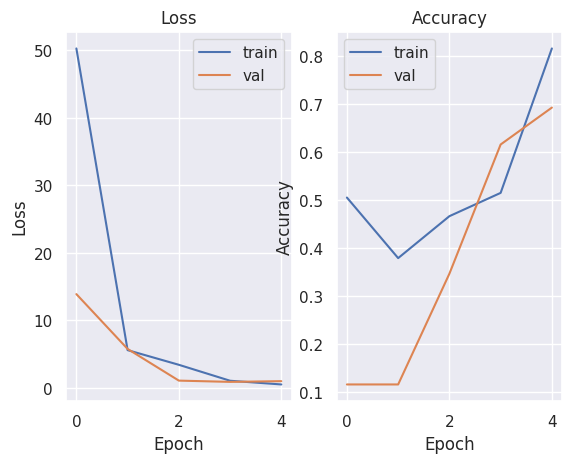

In [ ]:
plt.subplot(1, 2, 1)
sns.lineplot(history.history["loss"], label="train")
sns.lineplot(history.history["val_loss"], label="val")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
sns.lineplot(history.history["accuracy"], label="train")
sns.lineplot(history.history["val_accuracy"], label="val")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.6326 - loss: 0.8319
Test Loss: 0.8252
Test Accuracy: 0.6364


In [ ]:
y_pred = model.predict(X_test).argmax(axis=1)
print(classification_report(y_test, y_pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
              precision    recall  f1-score   support

           0       0.60      0.43      0.50         7
           1       0.64      0.90      0.75        20
           2       0.00      0.00      0.00         6

    accuracy                           0.64        33
   macro avg       0.41      0.44      0.42        33
weighted avg       0.52      0.64      0.56        33



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
